In [1]:
import pandas as pd
from scipy.stats import truncnorm
from plotnine import *

In [2]:
# win probabilities outputted by M3_Predictions.py
submission = pd.read_csv('mydata/mens/original_probabilities.csv')
submission.head()

,ID,Pred,TeamID_x,TeamID_y,SeedDiff,Seed_y
0,2021_1101_1104,0.805269,1104,1101,-12,14
1,2021_1101_1116,0.746119,1116,1101,-11,14
2,2021_1101_1124,0.901618,1124,1101,-13,14
3,2021_1101_1140,0.670191,1140,1101,-8,14
4,2021_1101_1155,0.503722,1155,1101,-7,14


In [3]:
submission['Pred'] = submission['Pred'].astype(float)
submission['SeedDiff'] = submission['SeedDiff'].astype(int)
submission['Seed_y'] = submission['Seed_y'].astype(int)
submission['TeamID_x'] = submission['TeamID_x'].astype(int)
submission['TeamID_y'] = submission['TeamID_y'].astype(int)

In [4]:
# function to set a min probability for the favorite based on the difference in seed
# used for 1 v 16, 2 v 15, 3 v 14
def set_prob_to_k(row, k, diff):
    if (row['SeedDiff'] < diff) and (row['Pred'] < k):
        if diff == -10 and row['Seed_y'] < 14:
            return row['Pred']
        else:
            return k
    else:
        return row['Pred']
    
submission['Pred'] = submission.apply(set_prob_to_k, axis = 1, args = (.78, -10)) # 3 vs 14 set to minimum 78%
submission['Pred'] = submission.apply(set_prob_to_k, axis = 1, args = (.92, -12)) # 2 v 15 set to minumim 92%
submission['Pred'] = submission.apply(set_prob_to_k, axis = 1, args = (.98, -14)) # 1 v 16 set to minimum 98%

submission = submission.drop(columns = ['SeedDiff', 'Seed_y'])

In [5]:
# Switches Pred to the (1 - Pred) if TeamID_x is not the lower ID as Pred needs to be the probability for the lower ID team
def switch_teams(row):
    idlist = row['ID'].split('_')
    prob = row['Pred']
    if row['TeamID_x'] != int(idlist[1]):
        row['Pred'] = 1 - prob
    row['TeamID_x'] = int(idlist[1])
    row['TeamID_y'] = int(idlist[2])
    return row

submission = submission.apply(switch_teams, axis = 1)

In [6]:
# File for names of teams
team_names = pd.read_csv('ncaam-march-mania-2021/MTeams.csv')[['TeamID', 'TeamName']]
team_names.head()

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [7]:
# Seeds for 2021
seeds = pd.read_csv('ncaam-march-mania-2021/MNCAATourneySeeds.csv').query('Season == 2021')[['TeamID', 'Seed']]
seeds.head()

,TeamID,Seed
2286,1276,W01
2287,1104,W02
2288,1400,W03
2289,1199,W04
2290,1160,W05


In [8]:
# join names with seeds
team_names_seeds = pd.merge(team_names, seeds, on = 'TeamID')
team_names_seeds.head()

,TeamID,TeamName,Seed
0,1101,Abilene Chr,W14
1,1104,Alabama,W02
2,1111,Appalachian St,X16a
3,1116,Arkansas,Z03
4,1124,Baylor,Z01


In [9]:
# Tournament slots for 2021
slots = pd.read_csv('ncaam-march-mania-2021/MNCAATourneySlots.csv').query('Season == 2021')[['Slot', 'StrongSeed', 'WeakSeed']]
slots.head()

,Slot,StrongSeed,WeakSeed
2251,R1W1,W01,W16
2252,R1W2,W02,W15
2253,R1W3,W03,W14
2254,R1W4,W04,W13
2255,R1W5,W05,W12


In [10]:
# join slots with names and seeds
team_slots = pd.merge(slots, team_names_seeds, left_on = ['StrongSeed'], right_on = ['Seed'])
team_slots = pd.merge(team_slots, team_names_seeds, left_on = ['WeakSeed'], right_on = ['Seed']).drop(columns = ['Slot', 'StrongSeed', 'WeakSeed', 'Seed_x', 'Seed_y'])
team_slots.head()

,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,1104,Alabama,1233,Iona
1,1400,Texas,1101,Abilene Chr
2,1199,Florida St,1422,UNC Greensboro
3,1160,Colorado,1207,Georgetown
4,1163,Connecticut,1268,Maryland


In [11]:
# function to switch slots so the lower id is in first slot
def switch_slots(row):
    if row['TeamID_x'] > row['TeamID_y']:
        team_id = row['TeamID_x']
        name = row['TeamName_x']
        row['TeamID_x'] = row['TeamID_y']
        row['TeamID_y'] = team_id
        row['TeamName_x'] = row['TeamName_y']
        row['TeamName_y'] = name
    return row

team_slots = team_slots.apply(switch_slots, axis = 1)
team_slots.head()

,TeamID_x,TeamName_x,TeamID_y,TeamName_y
0,1104,Alabama,1233,Iona
1,1101,Abilene Chr,1400,Texas
2,1199,Florida St,1422,UNC Greensboro
3,1160,Colorado,1207,Georgetown
4,1163,Connecticut,1268,Maryland


In [12]:
# merge submission with team slots to look at Round 1 probabilities
submission_r1 = pd.merge(submission, team_slots, on = ['TeamID_x', 'TeamID_y'])
submission_r1

,ID,Pred,TeamID_x,TeamID_y,TeamName_x,TeamName_y
0,2021_1101_1400,0.220000,1101,1400,Abilene Chr,Texas
1,2021_1155_1353,0.744473,1155,1353,Clemson,Rutgers
2,2021_1156_1222,0.048902,1156,1222,Cleveland St,Houston
3,2021_1116_1159,0.780000,1116,1159,Arkansas,Colgate
4,2021_1179_1455,0.683526,1179,1455,Drake,Wichita St
5,2021_1180_1228,0.020000,1180,1228,Drexel,Illinois
6,2021_1186_1242,0.169696,1186,1242,E Washington,Kansas
7,2021_1160_1207,0.700741,1160,1207,Colorado,Georgetown
8,2021_1210_1260,0.552085,1210,1260,Georgia Tech,Loyola-Chicago
9,2021_1213_1234,0.080000,1213,1234,Grand Canyon,Iowa


In [13]:
ids = list(submission_r1['ID'])

#The ML odds from William Hill, inputted manually, in order of IDs in submission_r1
vegas_odds_x = [340, # ABC vs Texas
               104, # clemson rutgers
                1400, # cleveland state houston
                -440, # arkansas colgate
                -110, # drake wichita
                1500, # drexel illinois
                475, # e washington kansas
                -260, # colorado georgetown
                200, # gt loyola
                900, # gcu iowa
                -7000, # baylor hartford
                -2000, # alabama iona
                285, # liberty oklahoma st
                -160, # uconn maryland
                -140, # msu ucla
                -105, # mizz oklahoma
                600, # morehead wvu
                -145, # app st norfolk st
                -130, # unc wisconsin
                240, # north texas purdue
                270, # ohio virginia
                -2400, # ohio st oral roberts
                350, # oregon st tenn
                -320, # creighton uscsb
                -125, # lsu sb
                -160, # sdsu syracuse
                -110, # mt st marys texas southern
                -700, # florda st uncg
                -200, # texas tech utah state
                -230, # oregon vcu
                -110, # Florida va tech
                -280 # Nova Winthrop
               ] # ML odds for TeamID_x (lower team id)

vegas_odds_y = [-440, # ABC vs Texas
               -126, # clemson rutgers
                -4000, # cleveland state houston
                340, # arkansas colgate
                -110, # drake wichita
                -4500, # drexel illinois
                -700, # e washington kansas
                210, # colorado georgetown
                -245, # gt loyola
                -1700, # gcu iowa
                1600, # baylor hartford
                1000, # alabama iona
                -360, # liberty oklahoma st
                140, # uconn maryland
                120, # msu ucla
                -114, # mizz oklahoma
                -900, # morehead wvu
                125, # app st norfolk st
                110, # unc wisconsin
                -300, # north texas purdue
                -340, # ohio virginia
                1100, # ohio st oral roberts
                -450, # oregon st tenn
                250, # creighton uscsb
                105, # lsu sb
                140, # sdsu syracuse
                -110, # mt st marys texas southern
                475, # florda st uncg
                170, # texas tech utah state
                190, # oregon vcu
                -110, # Florida va tech
                230 # Nova Winthrop
               ] # ML odds for TeamID_y (higher team id)

# make datframe of these odds
ml_odds = pd.DataFrame({'ID': ids, 'ML_x': vegas_odds_x, 'ML_y': vegas_odds_y})
ml_odds.head()

,ID,ML_x,ML_y
0,2021_1101_1400,340,-440
1,2021_1155_1353,104,-126
2,2021_1156_1222,1400,-4000
3,2021_1116_1159,-440,340
4,2021_1179_1455,-110,-110


In [14]:
# converts the ML odds to a win probability
def ml_to_win_probability(row, ml_col):
    
    # if team has plus odds (underdog)
    if row[ml_col] > 0:
        return (100 / (100 + row[ml_col]))
    
    # if team has negative odds (favorite)
    else:
        return ((-1 * row[ml_col] / (100 - row[ml_col])))
    
# makes columns of win probabilities from ML odds
ml_odds['WinProb_x'] = ml_odds.apply(lambda x: ml_to_win_probability(x, 'ML_x'), axis = 1)
ml_odds['WinProb_y'] = ml_odds.apply(lambda x: ml_to_win_probability(x, 'ML_y'), axis = 1)

ml_odds.head()

,ID,ML_x,ML_y,WinProb_x,WinProb_y
0,2021_1101_1400,340,-440,0.227273,0.814815
1,2021_1155_1353,104,-126,0.490196,0.557522
2,2021_1156_1222,1400,-4000,0.066667,0.975610
3,2021_1116_1159,-440,340,0.814815,0.227273
4,2021_1179_1455,-110,-110,0.523810,0.523810


In [15]:
# The ML odds are hedged so that Vegas makes money, so need to average them out to get the true win probability
# Calculating for team x only as the win probabilities in the Kaggle submission are for team x
ml_odds['VegasWinProb'] = 0.5 * (ml_odds['WinProb_x'] + (1 - ml_odds['WinProb_y']))

# only need the true win probability and ID
ml_odds = ml_odds[['ID', 'VegasWinProb']]
ml_odds.head()

,ID,VegasWinProb
0,2021_1101_1400,0.206229
1,2021_1155_1353,0.466337
2,2021_1156_1222,0.045528
3,2021_1116_1159,0.793771
4,2021_1179_1455,0.500000


In [16]:
# merge vegas odds with submission probabilities for round 1
submission_r1 = pd.merge(submission_r1, ml_odds, on = 'ID')

# Calculate absolute difference between my probabilities and Vegas'
submission_r1['AbsDiff'] = abs(submission_r1['VegasWinProb'] - submission_r1['Pred'])

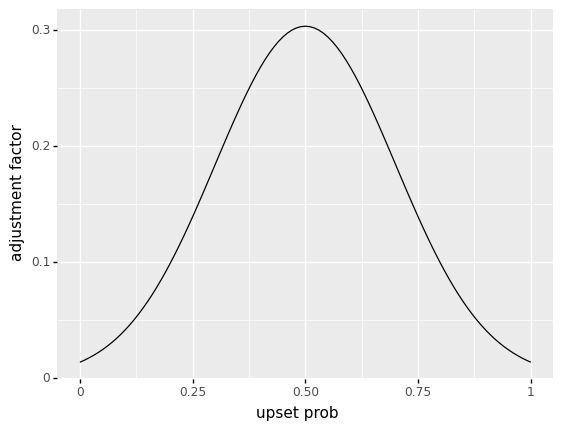

<ggplot: (-9223371892922548813)>

In [17]:
def get_adj_factor(p, x):
    if x > 0:
        return truncnorm.pdf(p, a = -2.5, b = 2.5, loc = 0.5, scale = 0.2) / (2 / x)
    else:
        return 0

# adjusts all probabiltiies for a given team
# positive adj means team is undervalued by model
# negative adj means team is overvalued by model

def team_adjustment(row, team_id, adj_50):
    idlist = row['ID'].split('_')
    
    # factor to add or subtract from the win probability, smaller at the tails than at the center and never goes outside of 0 and 1
    adj_factor = get_adj_factor(row['Pred'], abs(adj_50))
    
    # increase probability if given team is TeamID_x and adjustment is positive or given team is TeamID_y and adjustment is negative
    if (team_id == int(idlist[1]) and adj_50 > 0) or (team_id == int(idlist[2]) and adj_50 < 0):
        return row['Pred'] + adj_factor
        
    # decrease probability if given team is TeamID_y and adjustment is positive or given team is TeamID_x and adjustment is negative
    elif (team_id == int(idlist[2]) and adj_50 > 0) or (team_id == int(idlist[1]) and adj_50 < 0):
        return row['Pred'] - adj_factor
        
    else:
        return row['Pred']
    

# adjustments are in shape of truncated normal distribution
# interpretation of adj_50: approximate change in win probability for 50/50 game
# ie if you want to change a 50/50 game to 55/45, use an adj_50 of 0.05
# a greater adj_50 means a large adjustment factor

probs = [(0 + 0.01 * i) for i in range(101)]
ys = []
adj_50 = 0.3
for p in probs:
    ys.append(get_adj_factor(p, adj_50))

plot_df = pd.DataFrame({'x': probs, 'y': ys})
(ggplot(plot_df, aes(x = 'x', y = 'y')) + geom_line() + ylab('adjustment factor') + xlab('upset prob'))

In [18]:
# print submission_r1 ordering by the difference in win probability, look where to make above asjustments
submission_r1.sort_values('AbsDiff')

,ID,Pred,TeamID_x,TeamID_y,TeamName_x,TeamName_y,VegasWinProb,AbsDiff
7,2021_1160_1207,0.700741,1160,1207,Colorado,Georgetown,0.699821,0.000920
9,2021_1213_1234,0.080000,1213,1234,Grand Canyon,Iowa,0.077778,0.002222
2,2021_1156_1222,0.048902,1156,1222,Cleveland St,Houston,0.045528,0.003374
31,2021_1437_1457,0.722141,1437,1457,Villanova,Winthrop,0.716906,0.005235
30,2021_1196_1439,0.508506,1196,1439,Florida,Virginia Tech,0.500000,0.008506
11,2021_1104_1233,0.921621,1104,1233,Alabama,Iona,0.930736,0.009115
3,2021_1116_1159,0.780000,1116,1159,Arkansas,Colgate,0.793771,0.013771
0,2021_1101_1400,0.220000,1101,1400,Abilene Chr,Texas,0.206229,0.013771
10,2021_1124_1216,0.980000,1124,1216,Baylor,Hartford,0.963546,0.016454
21,2021_1326_1331,0.955293,1326,1331,Ohio St,Oral Roberts,0.938333,0.016959


In [19]:
get_adj_factor(0.54, 0.23)

0.22767714680384613

In [20]:
# look at Vegas odds, and see which teams the model undervalues that make sense (injuries, COVID, other reasons)
# and adjust their win probabilities for all games manually using function above

# Injuries to keep in mind
# John Fulkerson, Tenn
# Kyle Young, OSU
# Josh Primo, Alabama

# Undervalued by efficiency metrics
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1393, 0.04), axis = 1) # Syracuse
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1332, 0.12), axis = 1) # Oregon
#submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1397, 0.04), axis = 1) # Tennessee, Fulkerson
#submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1155, 0.02), axis = 1) # Clemson
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1433, 0.02), axis = 1) # VCU
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1325, 0.02), axis = 1) # Ohio
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1457, 0.02), axis = 1) # Winthrop
#submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1163, 0.02), axis = 1) # UConn

# Overvalued by efficiency metrics
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1455, -0.08), axis = 1) # Wichita
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1429, -0.06), axis = 1) # Utah St
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1159, -0.02), axis = 1) # Colgate
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1345, -0.04), axis = 1) # Purdue
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1199, -0.02), axis = 1) # Florida St
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1458, -0.02), axis = 1) # Wisconsin
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1361, -0.04), axis = 1) # SDSU
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1417, -0.02), axis = 1) # UCLA


# Injuries
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1437, -0.1), axis = 1) # Villanova
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1276, -0.06), axis = 1) # Michigan
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1328, -0.06), axis = 1) # Oklahoma

# Covid
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1438, -0.08), axis = 1) # Virginia
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1242, -0.02), axis = 1) # Kansas
submission['Pred'] = submission.apply(lambda x: team_adjustment(x, 1210, -0.23), axis = 1) # GT

In [21]:
# run same code to compare new altered probabilities to Vegas odds

# merge submission with team slots to look at Round 1 probabilities
submission_r1 = pd.merge(submission, team_slots, on = ['TeamID_x', 'TeamID_y'])

# merge vegas odds with submission probabilities for round 1
submission_r1 = pd.merge(submission_r1, ml_odds, on = 'ID')

# Calculate absolute difference between my probabilities and Vegas'
submission_r1['AbsDiff'] = abs(submission_r1['VegasWinProb'] - submission_r1['Pred'])

# print submission_r1 ordering by the difference in win probability
submission_r1.sort_values('AbsDiff')

,ID,Pred,TeamID_x,TeamID_y,TeamName_x,TeamName_y,VegasWinProb,AbsDiff
18,2021_1314_1458,0.545082,1314,1458,North Carolina,Wisconsin,0.544513,0.000569
7,2021_1160_1207,0.700741,1160,1207,Colorado,Georgetown,0.699821,0.000920
9,2021_1213_1234,0.080000,1213,1234,Grand Canyon,Iowa,0.077778,0.002222
2,2021_1156_1222,0.048902,1156,1222,Cleveland St,Houston,0.045528,0.003374
3,2021_1116_1159,0.787581,1116,1159,Arkansas,Colgate,0.793771,0.006191
30,2021_1196_1439,0.508506,1196,1439,Florida,Virginia Tech,0.500000,0.008506
11,2021_1104_1233,0.921621,1104,1233,Alabama,Iona,0.930736,0.009115
28,2021_1403_1429,0.657479,1403,1429,Texas Tech,Utah St,0.648148,0.009331
0,2021_1101_1400,0.220000,1101,1400,Abilene Chr,Texas,0.206229,0.013771
8,2021_1210_1260,0.327553,1210,1260,Georgia Tech,Loyola-Chicago,0.311594,0.015958


In [22]:
query = 'ID ==\'2021_1166_1438\'' # Virginia v Creighton
query = query + ' or ID ==\'2021_1364_1438\'' # Virginia v UCSB
query = query + ' or ID ==\'2021_1242_1425\'' # Kansas v USC
query = query + ' or ID ==\'2021_1242_1455\'' # Kansas v Wichita
query = query + ' or ID ==\'2021_1179_1242\'' # Kansas v Drake
query = query + ' or ID ==\'2021_1211_1328\'' # Gonzaga v Oklahoma
query = query + ' or ID ==\'2021_1211_1281\'' # Gonzaga v Missouri
query = query + ' or ID ==\'2021_1104_1268\'' # Alabama v Maryland
query = query + ' or ID ==\'2021_1196_1326\'' # Ohio State v Florida
query = query + ' or ID ==\'2021_1326_1439\'' # Virginia Tech vs Ohio State
query = query + ' or ID ==\'2021_1199_1422\'' # FSU v UNCG
query = query + ' or ID ==\'2021_1211_1313\'' # Gonzaga v Norfolk St
query = query + ' or ID ==\'2021_1179_1425\'' # Drake vs USC
query = query + ' or ID ==\'2021_1276_1411\'' # Michigan v Texas Southern
query = query + ' or ID ==\'2021_1140_1417\'' # BYU v UCLA
query = query + ' or ID ==\'2021_1333_1397\'' # Oregon St v Tenn
submission.query(query)

,ID,Pred,TeamID_x,TeamID_y
373,2021_1179_1242,0.341876,1179,1242
394,2021_1179_1425,0.370018,1179,1425
535,2021_1196_1326,0.397169,1196,1326
924,2021_1104_1268,0.708190,1104,1268
1012,2021_1211_1281,0.942798,1211,1281
1185,2021_1211_1313,0.980000,1211,1313
1372,2021_1211_1328,0.949042,1211,1328
1552,2021_1333_1397,0.301092,1333,1397
1690,2021_1364_1438,0.477552,1364,1438
1832,2021_1276_1411,0.976599,1276,1411


In [23]:
# make manual adjustments to round 1 win probabilities based on Vegas odds
submission.loc[1920, 'Pred'] =  0.85 # FSU v UNCG
submission.loc[2072, 'Pred'] = 0.45  # Virginia v Creighton
#submission.loc[, 'Pred'] =   # Kansas v Wichita
#submission.loc[, 'Pred'] =   # Virginia v UCSB
#submission.loc[, 'Pred'] =   # Kansas v USC
#submission.loc[, 'Pred'] =   # Kansas v Drake
#submission.loc[, 'Pred'] =   # Gonzaga v Oklahoma
#submission.loc[, 'Pred'] =   # Gonzaga v Missouri
submission.loc[924, 'Pred'] = 0.75  # Alabama v Maryland
submission.loc[535, 'Pred'] = 0.35  # Ohio State v Florida
submission.loc[2106, 'Pred'] = 0.75  # Virginia Tech vs Ohio State
submission.loc[1552, 'Pred'] = 0.75  # Oregon St v Tenn
submission.loc[394, 'Pred'] = 0.27  # Drake vs USC

In [24]:
query = 'ID ==\'2021_1166_1438\'' # Virginia v Creighton
query = query + ' or ID ==\'2021_1364_1438\'' # Virginia v UCSB
query = query + ' or ID ==\'2021_1242_1425\'' # Kansas v USC
query = query + ' or ID ==\'2021_1242_1455\'' # Kansas v Wichita
query = query + ' or ID ==\'2021_1179_1242\'' # Kansas v Drake
query = query + ' or ID ==\'2021_1211_1328\'' # Gonzaga v Oklahoma
query = query + ' or ID ==\'2021_1211_1281\'' # Gonzaga v Missouri
query = query + ' or ID ==\'2021_1104_1268\'' # Alabama v Maryland
query = query + ' or ID ==\'2021_1196_1326\'' # Ohio State v Florida
query = query + ' or ID ==\'2021_1326_1439\'' # Virginia Tech vs Ohio State
query = query + ' or ID ==\'2021_1199_1422\'' # FSU v UNCG
submission.query(query)

,ID,Pred,TeamID_x,TeamID_y
373,2021_1179_1242,0.341876,1179,1242
535,2021_1196_1326,0.350000,1196,1326
924,2021_1104_1268,0.750000,1104,1268
1012,2021_1211_1281,0.942798,1211,1281
1372,2021_1211_1328,0.949042,1211,1328
1690,2021_1364_1438,0.477552,1364,1438
1920,2021_1199_1422,0.850000,1199,1422
1974,2021_1242_1425,0.489346,1242,1425
2072,2021_1166_1438,0.450000,1166,1438
2106,2021_1326_1439,0.750000,1326,1439


### Kaggle Alterations

Kaggle allows two submission files, so it's best to alter the submission probabilities to maximize your chance of winning. To do this, I will take the most even first round matchup, and assign a probability of 1 in the first submission and a probability of 0 in the second submission. This matchup is guaranteed to happen (as it's the opening round) and I will benefit from the improvement in log loss on that matchup going from a log loss of around 0.69 to a log loss of 0

In [25]:
submission.query('ID ==\'2021_1196_1439\'')

,ID,Pred,TeamID_x,TeamID_y
2093,2021_1196_1439,0.508506,1196,1439


In [26]:
# Assign probabiltiy 1 to the most even first round matchup
# juding from submission_r1 above, the most even first round matchup is...
submission1 = submission.copy()[['ID', 'Pred']]
submission2 = submission.copy()[['ID', 'Pred']]
submission1.iloc[2093, 1] = 1   # Florida vs Virginia Tech, give Florida the full 100%
submission2.iloc[2093, 1] = 0   # Florida vs Virginia Tech, give Virginia Tech the full 100%

In [27]:
submission1.iloc[2093, :]

ID      2021_1196_1439
Pred                 1
Name: 2093, dtype: object

In [28]:
submission2.iloc[2093, :]

ID      2021_1196_1439
Pred                 0
Name: 2093, dtype: object

In [29]:
# write submissions to csv
submission.to_csv('mydata/mens/altered_probabilities.csv', index = False)
submission1.to_csv('mydata/mens/submission1_prob.csv', index = False)
submission2.to_csv('mydata/mens/submission2_prob.csv', index = False)